### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 22nd at 11.59pm CT
---

In [33]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Solution

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 

In [34]:
data = np.load("hw6_data_1.npy")

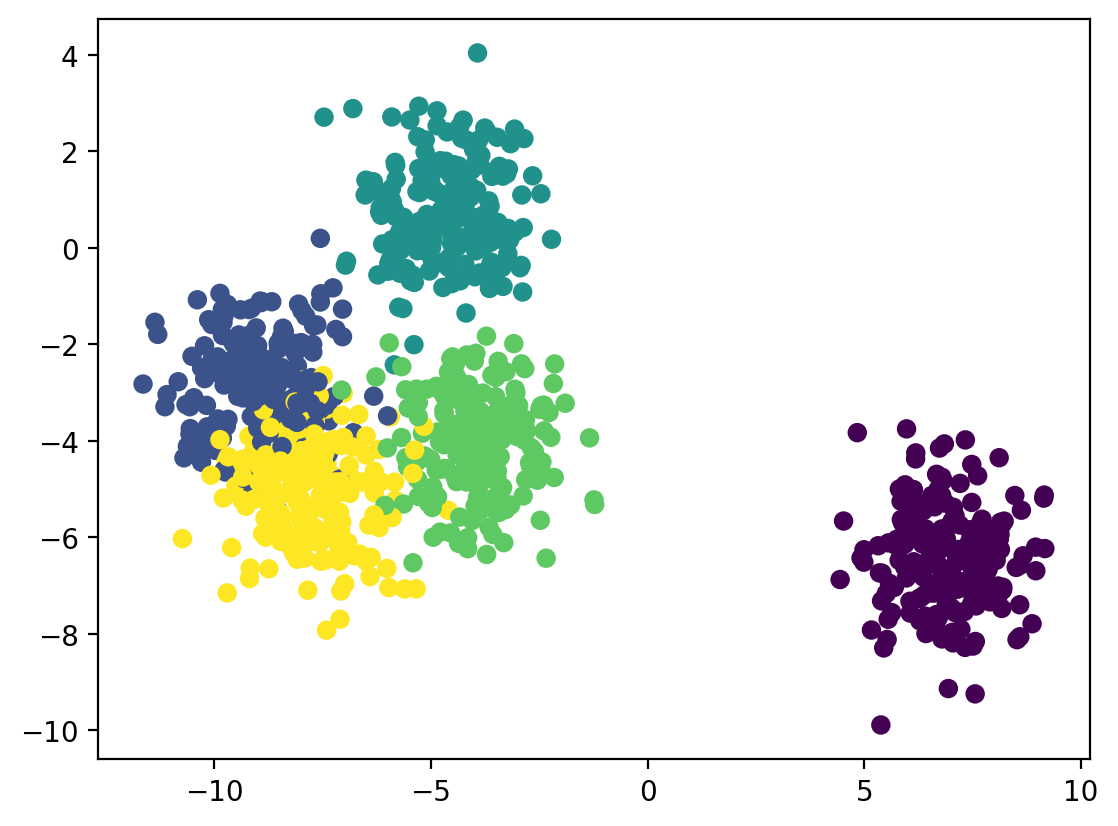

In [35]:
plt.scatter(data[:,0],data[:,1],c=data[:,2])
plt.show()

2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


In [36]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [37]:
bwrange = np.linspace(0.1, 1.0, 30) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) # Try each bandwidth with K-folds
grid.fit(data[:, 0:2]) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print("The best bandwidth of the distribution is: ", h_opt)

The best bandwidth of the distribution is:  0.4724137931034482


SRT: Good.

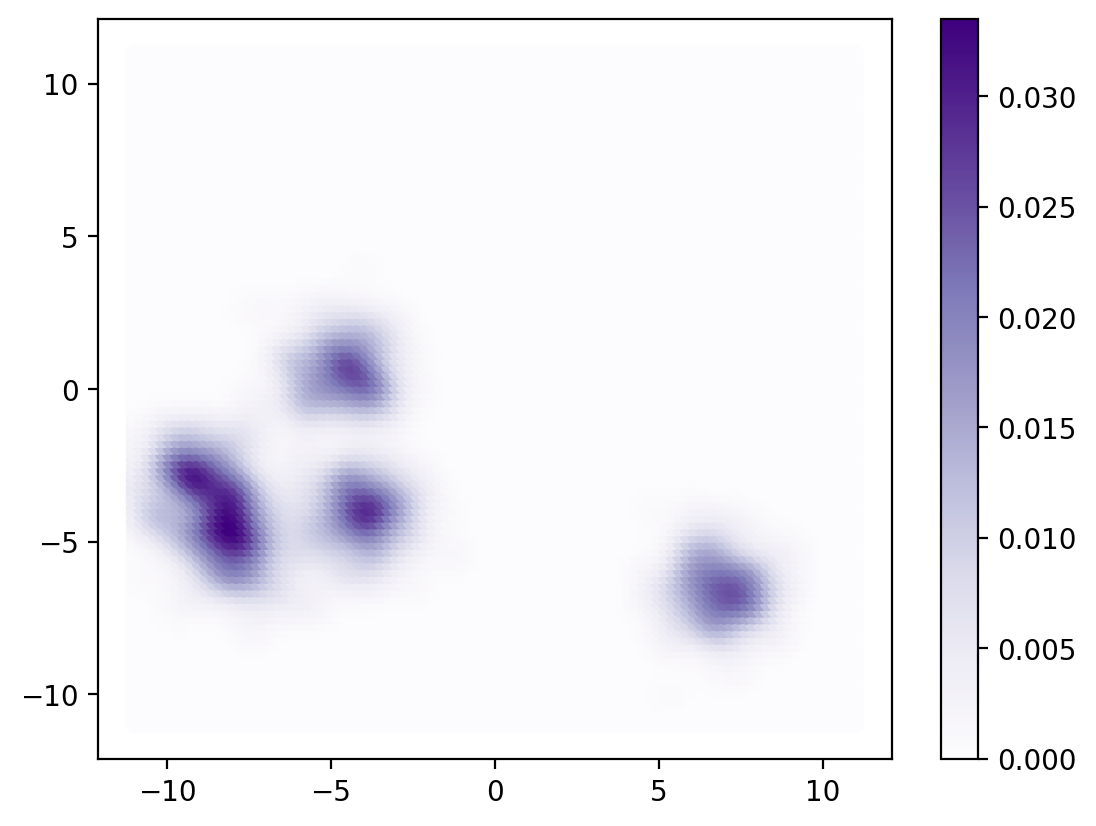

In [38]:
u = v = np.linspace(-11,11,100)

kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(data[:,0:2]) #fit the model to the data

Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(grid.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()
plt.show()

3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?

In [39]:
from astroML.density_estimation import KNeighborsDensity

In [40]:
# Compute density with Bayesian nearest neighbors
k=50
N = len(data[:,0:2])
tx = np.linspace(-10, 10, 1000)
ty = np.linspace(-10, 10, 1000)
t = np.array(np.meshgrid(tx,ty))
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(data[:, 0:2])
dens_nbrs = nbrs.eval(Xgrid) / N

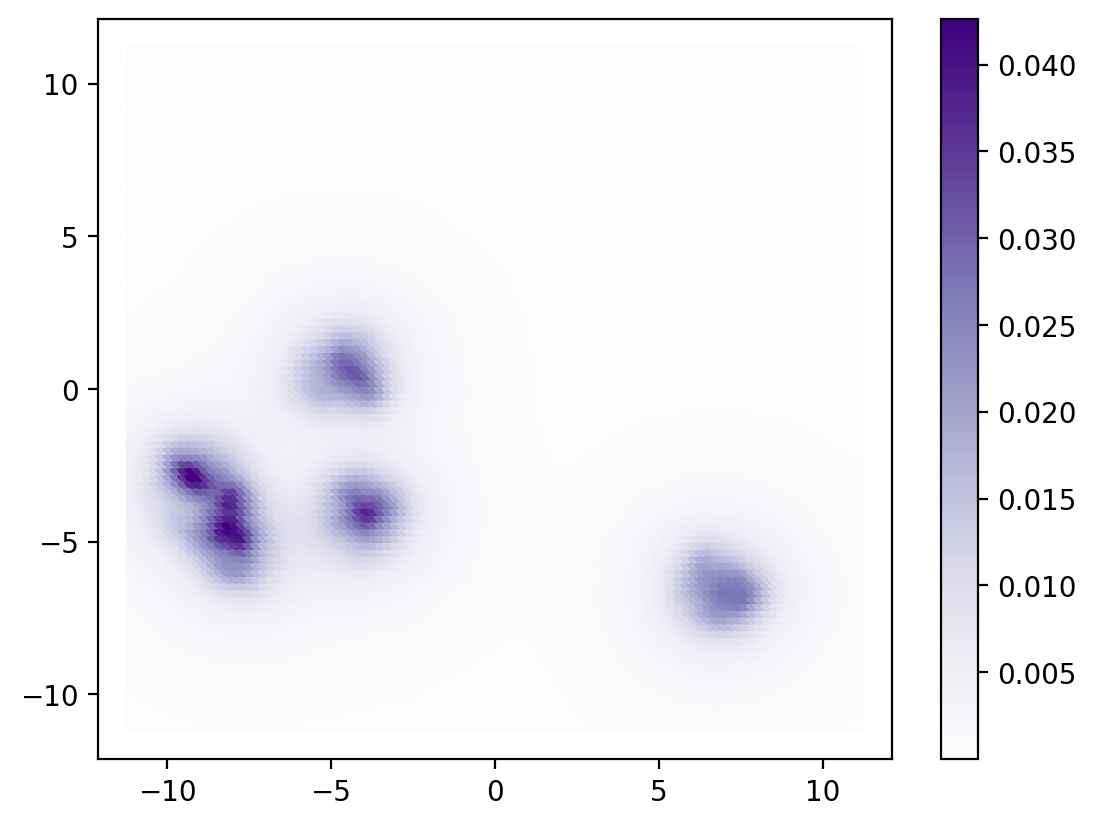

In [41]:
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_nbrs, 
            cmap="Purples", edgecolor="None")
plt.colorbar()
plt.show()

<font color="blue"> Around 50 neighbors gives us a similar set of graphs </font>

SRT: Yes, looks good.

4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [42]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0][0]
    sigma_y2 = C[1][1]
    sigma_xy = C[0][1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)
    
    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

In [11]:
from sklearn.mixture import GaussianMixture
from scipy import linalg

In [12]:
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(data[:,0:2])

# compute the AIC and the BIC
AIC = [m.aic(data[:,0:2]) for m in models]
BIC = [m.bic(data[:,0:2]) for m in models]

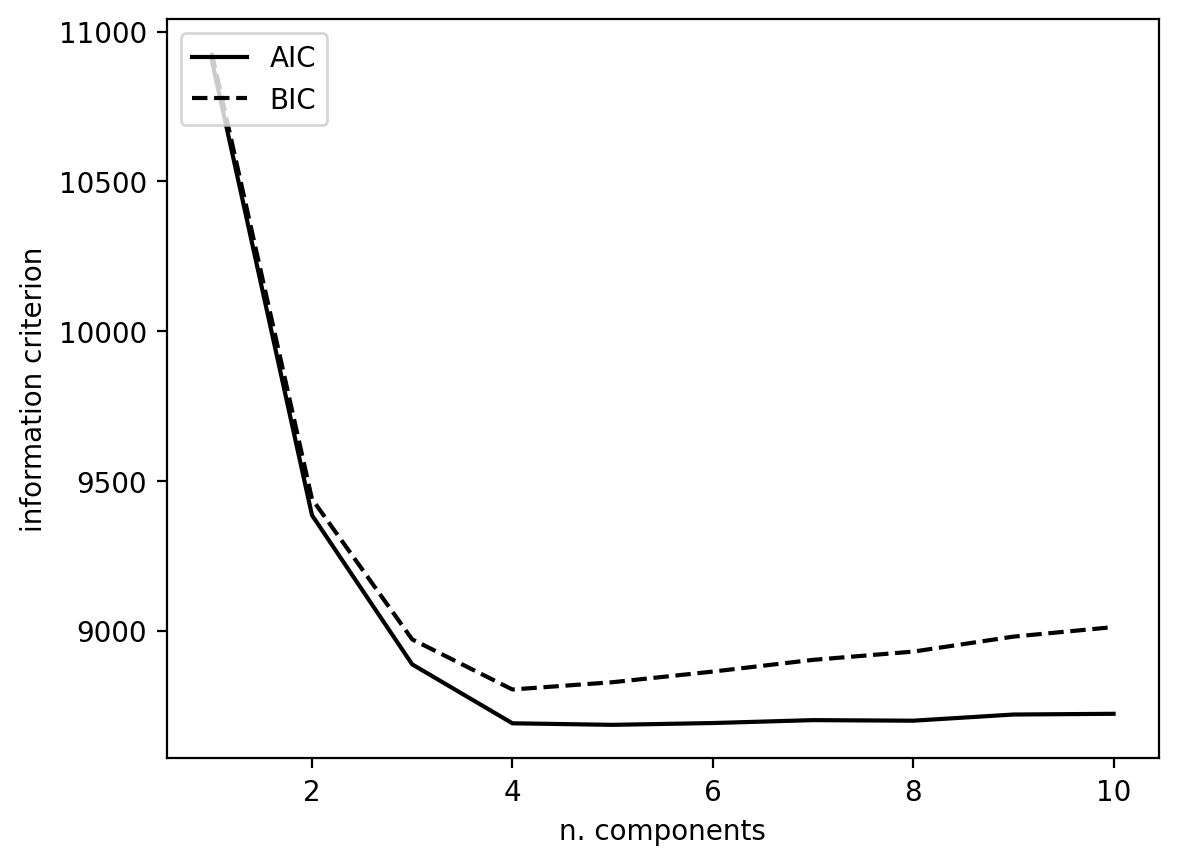

In [13]:
# plot 2: AIC and BIC
plt.plot(N, AIC, '-k', label='AIC')
plt.plot(N, BIC, '--k', label='BIC')
plt.xlabel('n. components')
plt.ylabel('information criterion')
plt.legend(loc=2)
plt.show()

<font color="blue"> The optimal number according to the BIC is about 5 components </font>

In [28]:
b_model = GaussianMixture(5, covariance_type="full").fit(data[:,0:2])

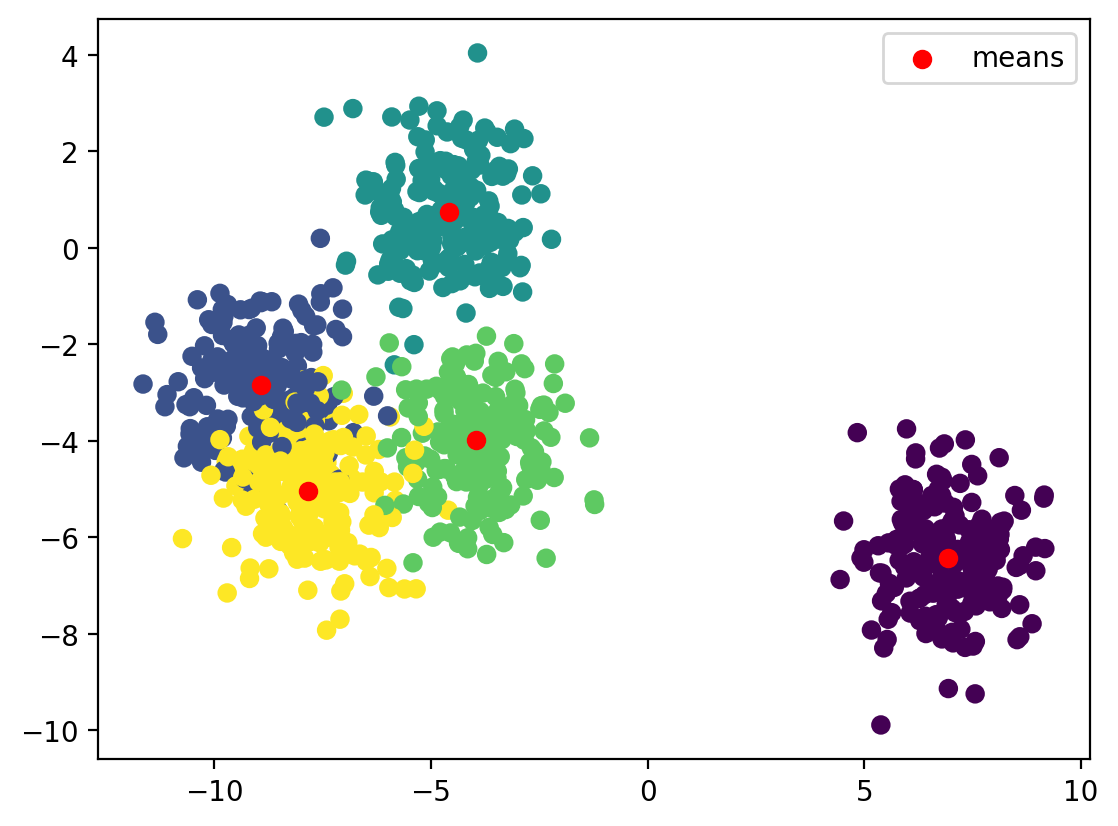

In [45]:
plt.scatter(data[:,0],data[:,1],c=data[:,2])
plt.scatter(b_model.means_[:,0],b_model.means_[:,1],c="r",label="means")
for i in range(len(b_model.means_)):
    p = linalg.eigh(b_model.covariances_[i])
    #draw_ellipse(b_model.means_[i],p)
plt.legend()
plt.show()

<font color="blue"> I can't get the covarience ellipses to show up, seems to be some kind of issue with the way that I found the eigenvector </font>

SRT: You were almost there. Instead of performing an eigen-analysis, you just needed to give it the covariance matrices themselves, i.e., `b_model.covariances_[i]`. -3 points.

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

In [16]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [17]:
n_clusters = 5
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
scaled_data = scaler.fit_transform(data[:,0:2])
clf.fit(scaled_data)

KMeans(n_clusters=5)

In [18]:
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
labels = clf.predict(scaled_data)

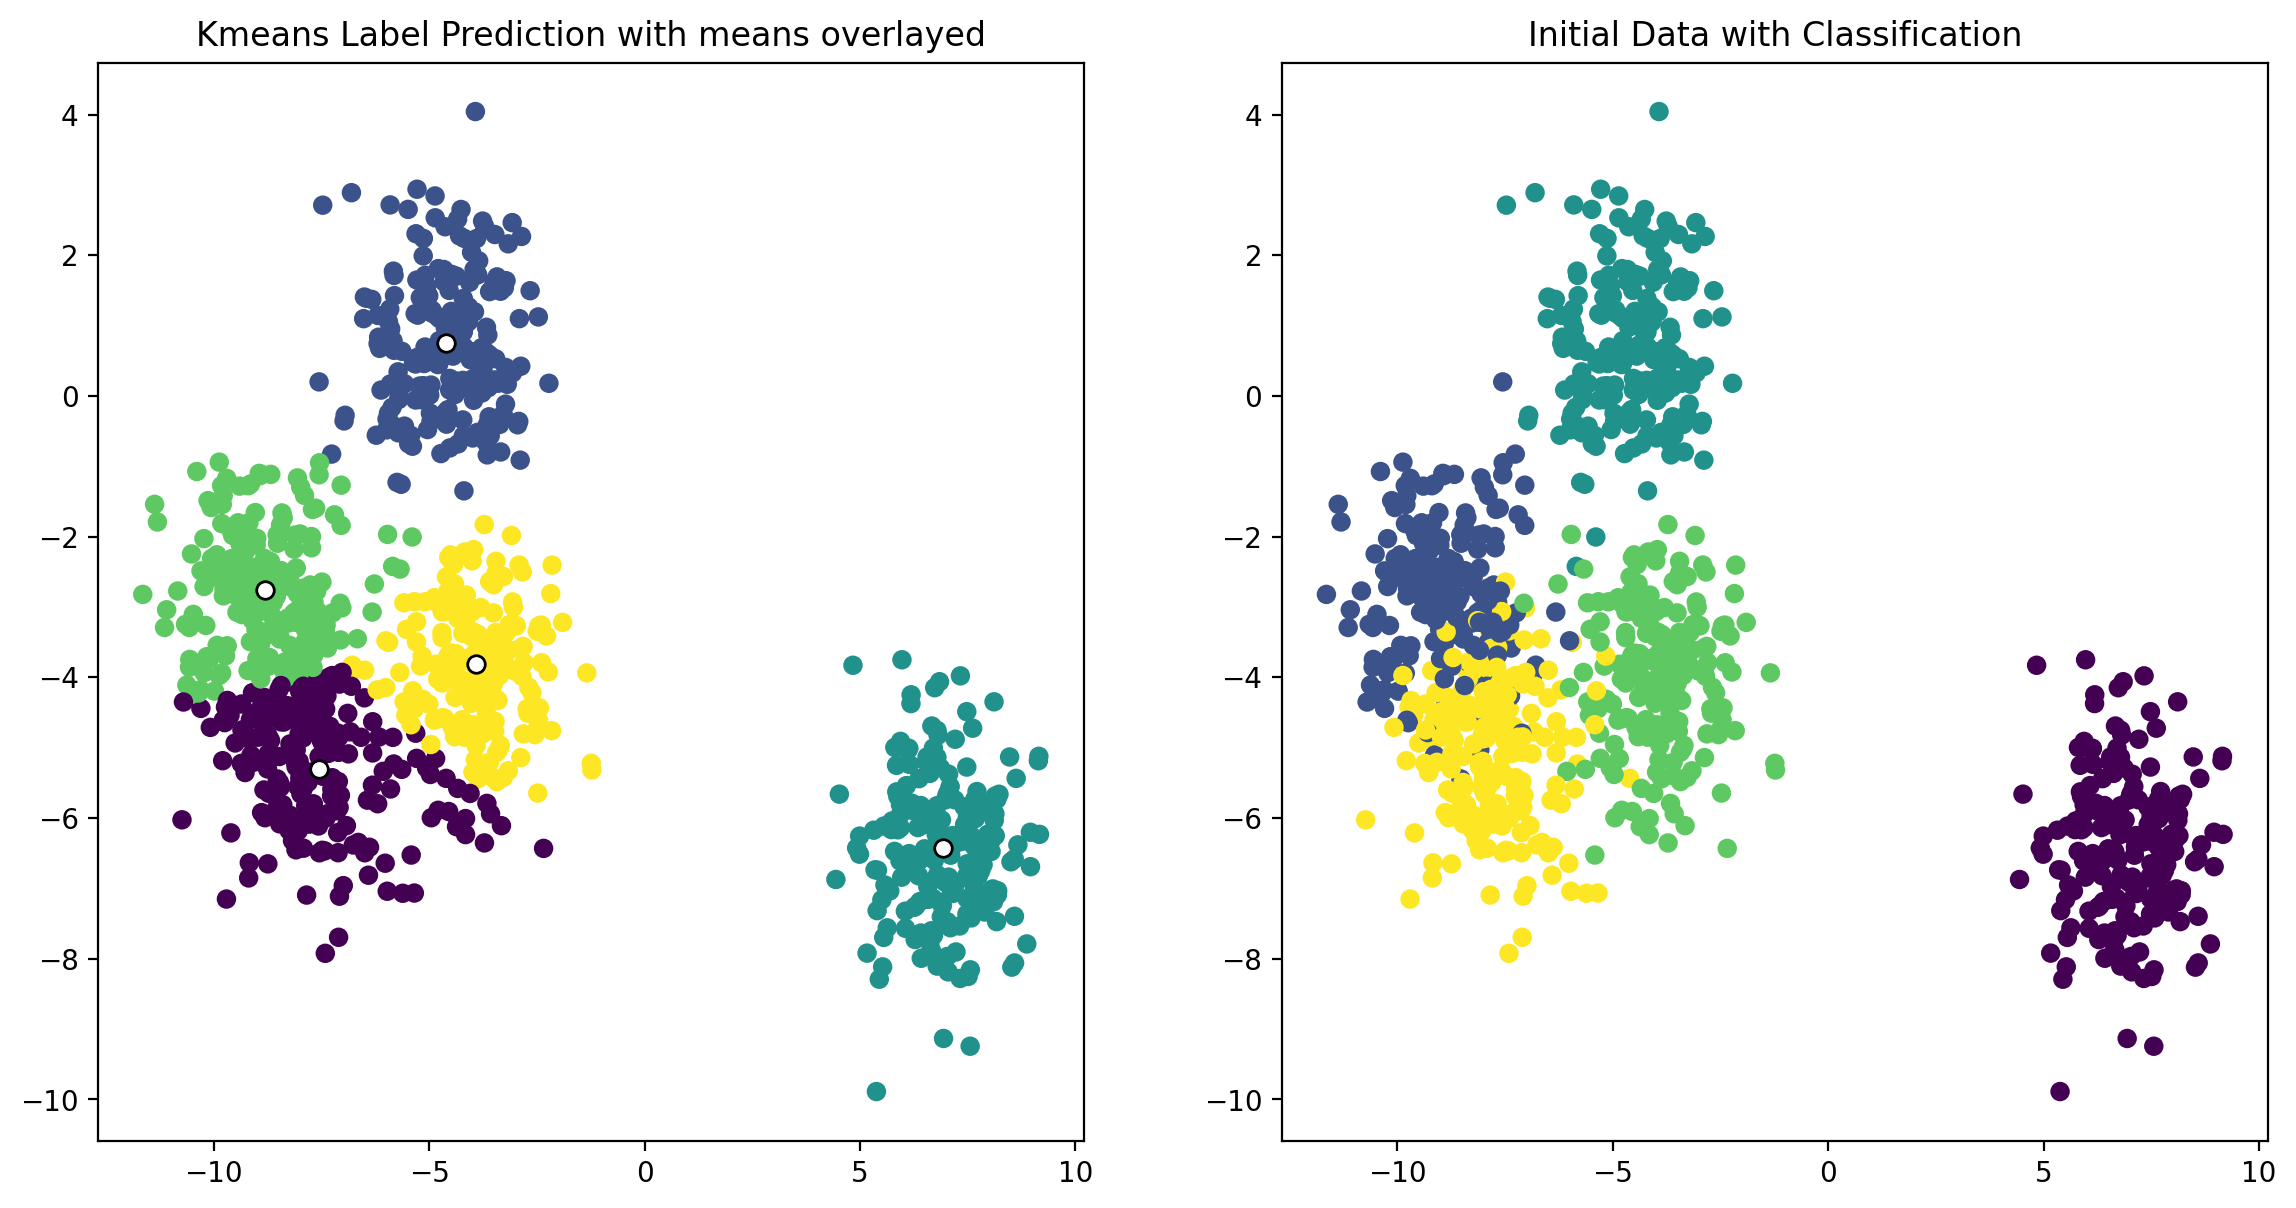

In [32]:
fig, axs = plt.subplots(1,2,figsize=(14,7))
# Figure 0
axs[0].scatter(data[:,0],data[:,1],c=labels)
axs[0].scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')
axs[0].set_title("Kmeans Label Prediction with means overlayed")

#Figure 1
axs[1].set_title("Initial Data with Classification")
axs[1].scatter(data[:,0],data[:,1],c=data[:,2])

plt.show()

SRT: Well done, Joe.

47/50